# 載入package

In [1]:
import numpy as np
import pandas as pd
from glob import glob
from toolz import pipe, partial
from os.path import join, splitext
from mpmath import mp

In [2]:
import numpy as np
from collections import defaultdict
from scipy.optimize import minimize
pd.set_option('display.max_columns', None)

In [3]:
from sklearn.preprocessing import LabelEncoder

In [4]:
from scipy.linalg import block_diag
from numpy.linalg import inv
import copy

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 整理資料

In [6]:
def get_data(sackmann_dir, tour='atp', keep_davis_cup=False):

    all_csvs = glob(join(sackmann_dir, f'*{tour}_matches_doubles_????.csv'))
    all_csvs = sorted(all_csvs, key=lambda x: int(splitext(x)[0][-4:]))

    levels_to_drop = ['C', 'S']

    if not keep_davis_cup:
        levels_to_drop.append('D')

    data = pipe(all_csvs,
                # Read CSV
                lambda y: map(partial(pd.read_csv, encoding="ISO=8859-1",index_col=False), y),
                # Drop NAs in important fields
                lambda y: map(lambda x: x.dropna(
                    subset=['winner1_name', 'loser1_name', 'winner2_name', 'loser2_name','score']),
                    y),
                # Drop retirements and walkovers
                # TODO: Make this optional
                lambda y: map(lambda x:
                              x[~x['score'].astype(str).str.contains(
                                'RET|W/O|DEF|nbsp|Def.')],
                              y),
                # Drop scores that appear truncated
                lambda y: map(lambda x: x[
                    x['score'].astype(str).str.len() > 4],
                    y),
                # Drop challengers and futures
                # TODO: Make this optional too
                lambda y: map(lambda x: x[
                    ~x['tourney_level'].isin(levels_to_drop)],
                    y),
                pd.concat,
                )

    round_numbers = {
        'R128': 1,
        'RR': 1,
        'R64': 2,
        'R32': 3,
        'R16': 4,
        'QF': 5,
        'SF': 6,
        'F': 7
    }

    # Drop rounds outside this list
    to_keep = data['round'].isin(round_numbers)
    data = data[to_keep]

    # Add a numerical round number
    data['round_number'] = data['round'].replace(round_numbers)

    # Add date information
    data['tourney_date'] = pd.to_datetime(
        data['tourney_date'].astype(int).astype(str), format='%Y%m%d')
    data['year'] = data['tourney_date'].dt.year

    # Sort by date and round and reset index
    data = data.sort_values(['tourney_date', 'round_number'])
    data = data.reset_index(drop=True)

    data['pts_won_serve_winner'] = data['w_1stWon'] + data['w_2ndWon']
    data['pts_won_serve_loser'] = data['l_1stWon'] + data['l_2ndWon']

    data['pts_played_serve_winner'] = data['w_svpt']
    data['pts_played_serve_loser'] = data['l_svpt']

    # Add serve % won
    data['spw_winner'] = (data['w_1stWon'] + data['w_2ndWon']) / data['w_svpt']
    data['spw_loser'] = (data['l_1stWon'] + data['l_2ndWon']) / data['l_svpt']

    return data

資料來自:https://github.com/JeffSackmann/tennis_atp

將雙打的資料整合起來

In [7]:
data = get_data('tennis_atp-master/tennis_atp-master/')

收集2010年至2019年的比賽

In [8]:
data = data[data['tourney_date'].dt.year >= 2010]
to_use = data[data['tourney_date'].dt.year <= 2019]

將資料儲存至csv檔

In [9]:
to_use.to_csv("double.csv",index=False)

In [10]:
Train = to_use[to_use['tourney_date'].dt.year <= 2017]

In [11]:
Test = to_use[to_use['tourney_date'].dt.year > 2017]

各資料集的場地資料

In [12]:
Train['surface'].value_counts()

Hard     5548
Clay     3112
Grass    1199
Name: surface, dtype: int64

In [13]:
Test['surface'].value_counts()

Hard     1464
Clay      767
Grass     340
Name: surface, dtype: int64

In [14]:
to_use['surface'].value_counts()

Hard     7012
Clay     3879
Grass    1539
Name: surface, dtype: int64

資料集的比賽場數

|Dataset|Train|Test|Total|
|---|---|---|---|
|Begin|2010|2018|2010|
|End|2017|2019|2019|
|Hard|5548|1464|7012|
|Clay|3112|767|3879|
|Grass|1199|340|1539|
|Total|9859|2571|12430|

# B-T Model

In [15]:
Train = Train.reset_index()
to_use = to_use.reset_index()

In [16]:
def calculate_ratings(data,start_mean = 1500, start_var = 20**2,beta_square = 3**2):
    '''
    Args:
        data: The atp matches double game
        start_mean: Each of the player start with performance mean
        start_var: Each of the player start with performance variance
        beta_square: the bias of the uncertainty about the actual performance X
    Return: 
        player_rate: each player skill
    '''
    winner_double = list(zip(data['winner1_name'],data['winner2_name']))
    loser_double = list(zip(data['loser1_name'],data['loser2_name']))
    player_double = list(zip(data['winner1_name'],data['winner2_name'],data['loser1_name'],data['loser2_name']))
    prior_rating = defaultdict(lambda: (start_mean, start_var))
    player_rating = list()
    total_discrepancy = 0
    for game in np.arange(data.shape[0]):
        # check whether the player has play before
        current_players = player_double[game]
        for player in current_players:
            if player not in prior_rating:
                prior_rating[player]
        # collect prior rating in player_rating        
        player_rating.append(prior_rating.copy())
        
        new_rating = prior_rating.copy()
        # each player mean & variance
        winner1_mean,winner1_var = new_rating[current_players[0]]
        winner2_mean,winner2_var = new_rating[current_players[1]]
        loser1_mean,loser1_var = new_rating[current_players[2]]
        loser2_mean,loser2_var = new_rating[current_players[3]]
        # calculate team meam & variance
        winner_mean = sum([winner1_mean,winner2_mean])
        winner_var = sum([winner1_var,winner2_var])
        loser_mean = sum([loser1_mean,loser2_mean])
        loser_var = sum([loser1_var,loser2_var])
        # calculate c_iq
        c_iq = np.sqrt(winner_var + loser_var + 2 * beta_square)
        # calculate p_iq ,p_qi   p_iq是指預期比賽結果
        p_iq = np.exp(winner_mean/c_iq)/(np.exp(winner_mean/c_iq) + np.exp(loser_mean/c_iq))
        p_qi = np.exp(loser_mean/c_iq)/(np.exp(winner_mean/c_iq) + np.exp(loser_mean/c_iq))
        # sum discrepancy
        discrepancy = -np.log(p_iq)
        total_discrepancy += discrepancy
        # define s 比賽結果
        winner_s, loser_s = 1, 0        
        # calculate delta_q, delta_i
        delta_q = winner_var/c_iq*(winner_s-p_iq)
        delta_i = loser_var/c_iq*(loser_s-p_qi)
        # calculate omega_i, omega_q
        omega_i = delta_q
        omega_q = delta_i
        # Indiviual skill update
        # update winner
        new_rating[current_players[0]] = (winner1_mean + winner1_var/winner_var*omega_i, winner1_var)
        new_rating[current_players[1]] = (winner2_mean + winner2_var/winner_var*omega_i, winner2_var)
        # update loser
        new_rating[current_players[2]] = (loser1_mean + loser1_var/loser_var*omega_q, loser1_var)
        new_rating[current_players[3]] = (loser2_mean + loser2_var/loser_var*omega_q, loser2_var)
        # update prior rating
        prior_rating = new_rating
    return player_rating, total_discrepancy        

In [17]:
def optimize_parameter(
    data, 
    start_variance= 10 ** 2, 
    beta_square = 3 ** 2,
    verbose = True,
    tolerance = 1e-2,
):
    '''Fits the parameters in B-T model.
    Args:
    winners: The array of winners for each of N contests, of shape [N, 2].
    losers: The array of losers for each of N contests, of shape [N, 2].
    surface: The array of surfaces for each of N contest, of shape [N, 3].
    beta: The uncontral variances of the game
    start_variance_1: The initial variance of the surface 1
    verbose: Whether or not to print the progress of the optimisation.
    tolerance: The tolerance required for the optimisation to successfully terminate.
    '''
    def fun_to_minimize(theta):
        # Constrain
        variance = theta 
        _, discrepancy = calculate_ratings(data = data,start_mean = 1500,start_var = variance ,beta_square = beta_square)
        
        if verbose:
            print('variance: {} ; discrepancy: {}'.format(variance[0],discrepancy[0]))
        return discrepancy
    
    opt_result = minimize(fun_to_minimize,
                          np.array([start_variance],dtype='float'),
                          method='Nelder-Mead',
                          tol=tolerance,)
    return (opt_result.success, {'variance':opt_result.x[0]})

In [18]:
trian_parameter = optimize_parameter(data = Train, start_variance = 10)

variance: 10.0 ; discrepancy: 6404.590887708042
variance: 10.5 ; discrepancy: 6409.224045954827
variance: 9.5 ; discrepancy: 6399.682505756196
variance: 9.0 ; discrepancy: 6394.47634538922
variance: 8.0 ; discrepancy: 6383.071619223773
variance: 7.0 ; discrepancy: 6370.164121686069
variance: 5.0 ; discrepancy: 6339.0301431012085
variance: 3.0 ; discrepancy: 6301.922318766755


<ipython-input-16-bd0ad125cc6a>:40: RuntimeWarning: overflow encountered in exp
  p_iq = np.exp(winner_mean/c_iq)/(np.exp(winner_mean/c_iq) + np.exp(loser_mean/c_iq))
<ipython-input-16-bd0ad125cc6a>:40: RuntimeWarning: invalid value encountered in true_divide
  p_iq = np.exp(winner_mean/c_iq)/(np.exp(winner_mean/c_iq) + np.exp(loser_mean/c_iq))
<ipython-input-16-bd0ad125cc6a>:41: RuntimeWarning: overflow encountered in exp
  p_qi = np.exp(loser_mean/c_iq)/(np.exp(winner_mean/c_iq) + np.exp(loser_mean/c_iq))
<ipython-input-16-bd0ad125cc6a>:41: RuntimeWarning: invalid value encountered in true_divide
  p_qi = np.exp(loser_mean/c_iq)/(np.exp(winner_mean/c_iq) + np.exp(loser_mean/c_iq))


variance: -1.0 ; discrepancy: nan
variance: 5.0 ; discrepancy: 6339.0301431012085
variance: 1.0 ; discrepancy: 6305.318872631091
variance: 2.0 ; discrepancy: 6287.701093913006
variance: 1.0 ; discrepancy: 6305.318872631091
variance: 2.5 ; discrepancy: 6293.522571950313
variance: 1.5 ; discrepancy: 6288.2491967408705
variance: 1.75 ; discrepancy: 6286.784612707816
variance: 1.5 ; discrepancy: 6288.2491967408705
variance: 1.875 ; discrepancy: 6287.009478307857
variance: 1.625 ; discrepancy: 6287.146301919625
variance: 1.8125 ; discrepancy: 6286.831909991534
variance: 1.6875 ; discrepancy: 6286.883417181041
variance: 1.78125 ; discrepancy: 6286.791034614663
variance: 1.71875 ; discrepancy: 6286.8146827969085
variance: 1.765625 ; discrepancy: 6286.783392586518
variance: 1.78125 ; discrepancy: 6286.791034614663
variance: 1.7578125 ; discrepancy: 6286.782878897991


In [19]:
trian_parameter[1]

{'variance': 1.7578125}

觀察最後一天的每位選手實力參數

## accuracy

In [20]:
def accuracy(Train, to_use, variance):
    '''
    Args:
        player_rating: 根據之前訓練出的每個時段各選手的評分
        data: 資料集
    Return:
        accurate : the accuracy of the model
    '''
    count = 0
    total = 0
    players_rating = calculate_ratings(to_use,start_mean = 1500,start_var = variance ,beta_square = 3**2)
    for i in range(Train.shape[0],to_use.shape[0]):
        # get the current winners & losers name
        data_i = to_use.iloc[i,:]
        current_winner1, current_winner2 = data_i['winner1_name'], data_i['winner2_name']
        current_loser1, current_loser2 = data_i['loser1_name'], data_i['loser2_name']
        # get the current player the prior rating 
        winner1_rating, winner2_rating = players_rating[0][i][current_winner1][0],players_rating[0][i][current_winner2][0]
        loser1_rating, loser2_rating = players_rating[0][i][current_loser1][0],players_rating[0][i][current_loser2][0]
        # get the team rating
        winner_team = sum([winner1_rating, winner2_rating])
        loser_team = sum([loser1_rating, loser2_rating])
        # count the correct prediction
        if winner_team > loser_team:
            count +=1
        total +=1
    accurate = count / total
    return accurate

In [21]:
double_accuracy = accuracy(Train,to_use, trian_parameter[-1]['variance'])

In [22]:
print('The accuracy of model = {:.4f}%'.format(double_accuracy *100))

The accuracy of model = 63.1661%


## loglikelihood

$P(team\  i\  beats\  q) = (\dfrac{e^{\theta_i/c_{iq}}}{e^{\theta_i/c_{iq}} + e^{\theta_q/c_{iq}}})^{s_{iq}}$

$likelihood = \prod f_{iq}(z)$

$loglikelihood = log(likelihood)$

In [23]:
def model_meanloglikelihood(Train, to_use, variance,beta_square):
    '''
    Args:
        player_rating: 根據之前訓練出的每個時段各選手的評分
        data: 資料集
    Return:
        loglikelihood : the loglikelihood of the model
    '''
    loglikelihood = 0
    players_rating = calculate_ratings(to_use,start_mean = 1500,start_var = variance ,beta_square = beta_square)
    for i in range(Train.shape[0],to_use.shape[0]):
        # get the current winners & losers name
        data_i = to_use.iloc[i,:]
        current_winner1, current_winner2 = data_i['winner1_name'], data_i['winner2_name']
        current_loser1, current_loser2 = data_i['loser1_name'], data_i['loser2_name']
        # get the current player the prior rating 
        winner1_rating, winner2_rating = players_rating[0][i][current_winner1][0],players_rating[0][i][current_winner2][0]
        loser1_rating, loser2_rating = players_rating[0][i][current_loser1][0],players_rating[0][i][current_loser2][0]
        # get the current player the prior variance 
        winner1_var, winner2_var = players_rating[0][i][current_winner1][1],players_rating[0][i][current_winner2][1]
        loser1_var, loser2_var = players_rating[0][i][current_loser1][1],players_rating[0][i][current_loser2][1]
        # get the team rating
        winner_mean = sum([winner1_rating, winner2_rating])
        winner_var = sum([winner1_var, winner2_var])
        loser_mean = sum([loser1_rating, loser2_rating])
        loser_var = sum([loser1_var, loser2_var])
        # get the c_iq
        c_iq = np.sqrt(winner_var + loser_var + 2 * beta_square)
        # Likelihood
        mp.dps = 30
        data_i_loglikelihood = mp.log((mp.exp(winner_mean/c_iq)/(mp.exp(winner_mean/c_iq) + mp.exp(loser_mean/c_iq))))
        # calculate loglikelihood
        loglikelihood +=data_i_loglikelihood
    return loglikelihood/(to_use.shape[0]-Train.shape[0])

In [24]:
double_loglikelihood = model_meanloglikelihood(Train,to_use,trian_parameter[-1]['variance'],beta_square = 3**2)

In [25]:
print('The Mean log-likelihood of model = {}'.format(double_loglikelihood))

The Mean log-likelihood of model = -0.639251873582199954553493508426


# 結果

In [26]:
print('The accuracy of model = {:.4f}%'.format(double_accuracy *100))
print('The Mean log-likelihood of model = {}'.format(double_loglikelihood))

The accuracy of model = 63.1661%
The Mean log-likelihood of model = -0.639251873582199954553493508426


# Ratings

In [27]:
def ratings(Train , to_use, variance):
    '''
    return winners rating & losers rating
    '''
    winner = []
    loser = []
    players_rating = calculate_ratings(to_use,start_mean = 1500,start_var = variance ,beta_square = 3**2)
    for i in range(Train.shape[0],to_use.shape[0]):
        # get the current winners & losers name
        data_i = to_use.iloc[i,:]
        current_winner1, current_winner2 = data_i['winner1_name'], data_i['winner2_name']
        current_loser1, current_loser2 = data_i['loser1_name'], data_i['loser2_name']
        # get the current player the prior rating 
        winner1_rating, winner2_rating = players_rating[0][i][current_winner1][0],players_rating[0][i][current_winner2][0]
        loser1_rating, loser2_rating = players_rating[0][i][current_loser1][0],players_rating[0][i][current_loser2][0]
        # get the team rating
        winner_team = sum([winner1_rating, winner2_rating])
        loser_team = sum([loser1_rating, loser2_rating])
        winner.append(winner_team)
        loser.append(loser_team)
    return winner, loser

In [28]:
winner, loser = ratings(Train,to_use, trian_parameter[-1]['variance'])

In [29]:
rating = pd.DataFrame({'winner':winner,'loser':loser})
rating['Difference'] = rating['winner'] - rating['loser']
rating['correct'] = rating['Difference'].apply(lambda x:True if x > 0 else False)

In [30]:
rating['diff'] = rating['Difference'].apply(lambda x:abs(x))

In [31]:
rating

,winner,loser,Difference,correct,diff
0,3010.570711,3000.421956,10.148755,True,10.148755
1,3000.253478,2999.077010,1.176468,True,1.176468
2,3001.696243,3004.654486,-2.958243,False,2.958243
3,3002.898307,3002.968231,-0.069923,False,0.069923
4,3001.936928,3002.601569,-0.664642,False,0.664642
...,...,...,...,...,...
2566,3006.817576,3008.102691,-1.285115,False,1.285115
2567,3007.706471,3007.830859,-0.124388,False,0.124388
2568,3010.503171,3008.661270,1.841901,True,1.841901
2569,3007.475149,3009.415621,-1.940472,False,1.940472


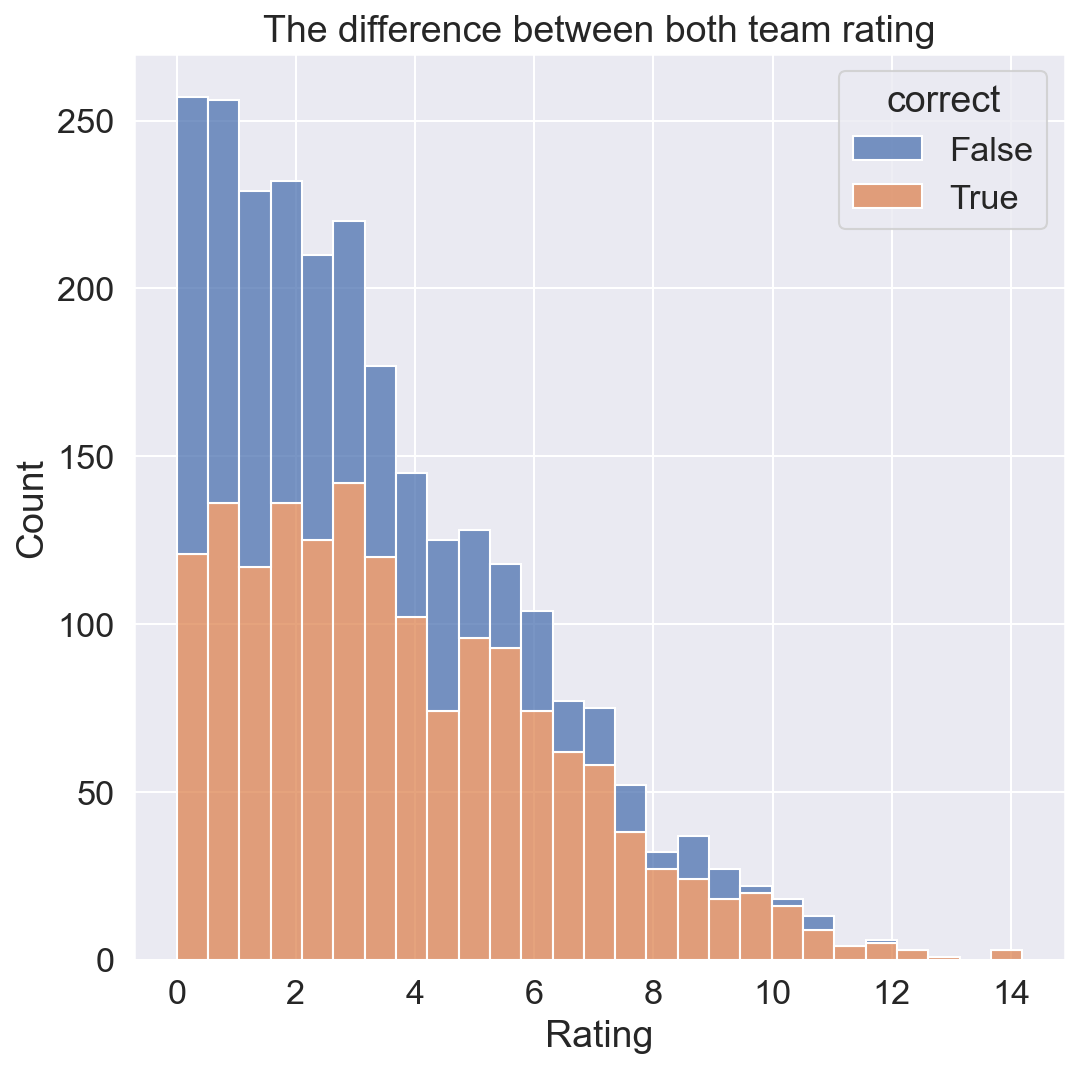

In [32]:
sns.set(font_scale = 1.5)
plt.figure(figsize= (8,8),dpi =150)
diff = sns.histplot(data = rating , x = rating['diff'],hue = 'correct',multiple="stack")
diff.set(xlabel = 'Rating',
         title = 'The difference between both team rating')
plt.savefig('C:/Users/ching/Desktop/paper/image/no_variance_diff.png')

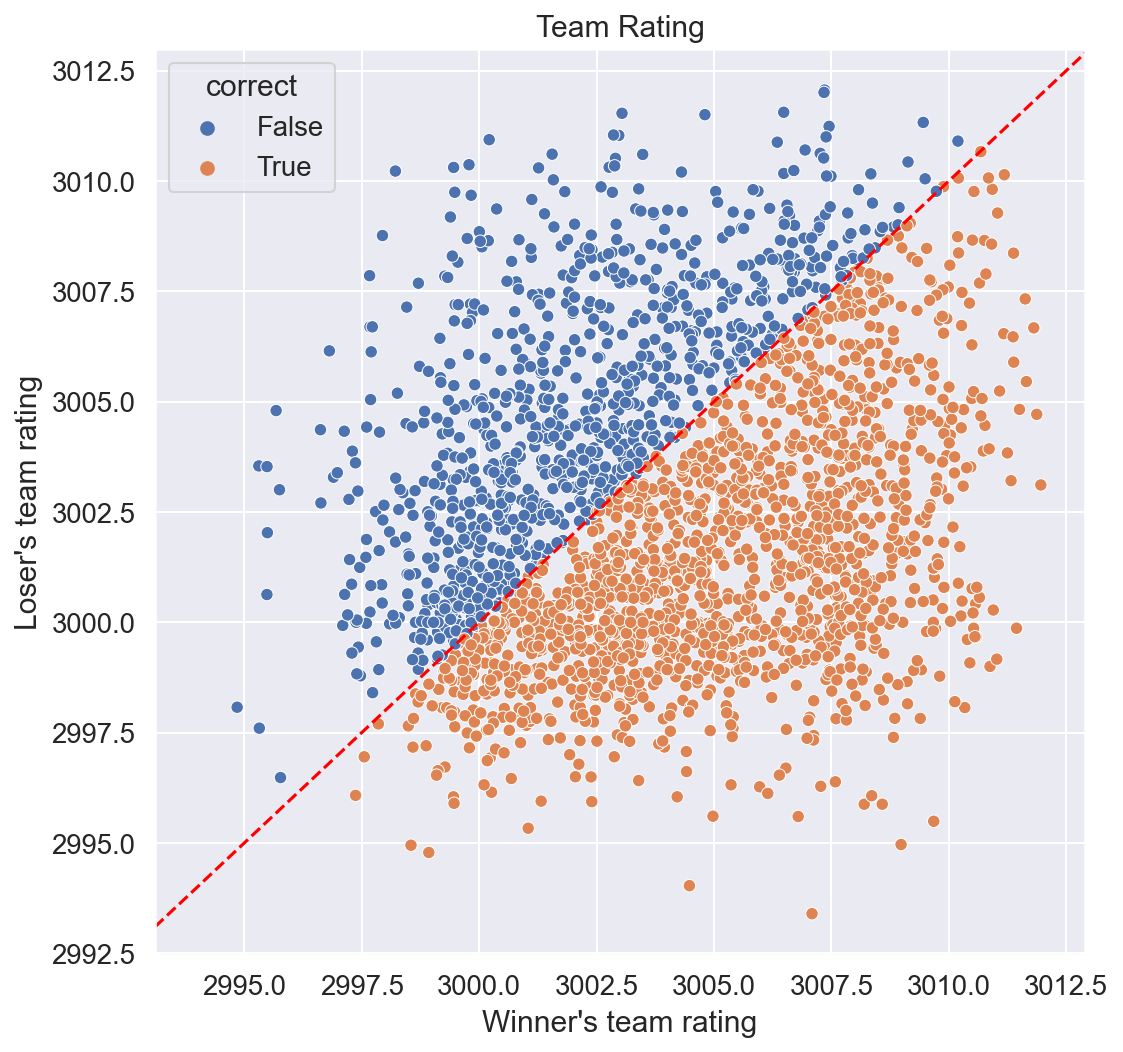

In [33]:
sns.set(font_scale = 1.2)
plt.figure(figsize= (8,8),dpi =150)
c = sns.scatterplot(x=winner,y=loser,data = rating,hue = 'correct')
plt.title('Team Rating')
plt.xlabel('Winner\'s team rating')
plt.ylabel('Loser\'s team rating')
c.axline((2994,2994),(3012,3012),color = 'red',linestyle = '--')
plt.savefig('C:/Users/ching/Desktop/paper/image/no_variance_rating.png')